In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import feature_extraction, linear_model, model_selection, preprocessing 
# Feature extraction allows extraction of features in a format supported my ML algs from datasets containing text and image.
# Linear_model: linear regression
# Model_selection: chooses estimators and parameters.
# preprocessing: functions and transformer classes that change raw feature vectors into a more preferable form for estimators that are downstream.
import re 
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer

**This is an older project of mine. I hope to add more to this when I am slightly more proficient in TensorFlow. Feel free to give me your thoughts/advice on this!**

# **Import the data, remove missing values, and analyse possible features**

In [2]:
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv") 

In [3]:
# Get an idea of what the dataset looks like.
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
# Find the number of missing data points per column
missing_values = train_df.isnull().sum()
print(missing_values)

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


In [5]:
# Fill missing values
train_df.fillna('0', inplace=True)


In [6]:
# Extract texts and labels
texts = list(train_df.text)
labels = list(train_df.target)


In [7]:
# Find how frequently each keyword occurs and create a DataFrame of the keywords and their associated frequencies.
keyword = train_df.groupby("keyword")["target"].count()
keyword_df = pd.DataFrame(data={"keyword": keyword.index, "count": keyword.values}).sort_values(by=["count"], ascending=False)
print(keyword)

keyword
0                      61
ablaze                 36
accident               35
aftershock             34
airplane%20accident    35
                       ..
wounded                37
wounds                 33
wreck                  37
wreckage               39
wrecked                39
Name: target, Length: 222, dtype: int64


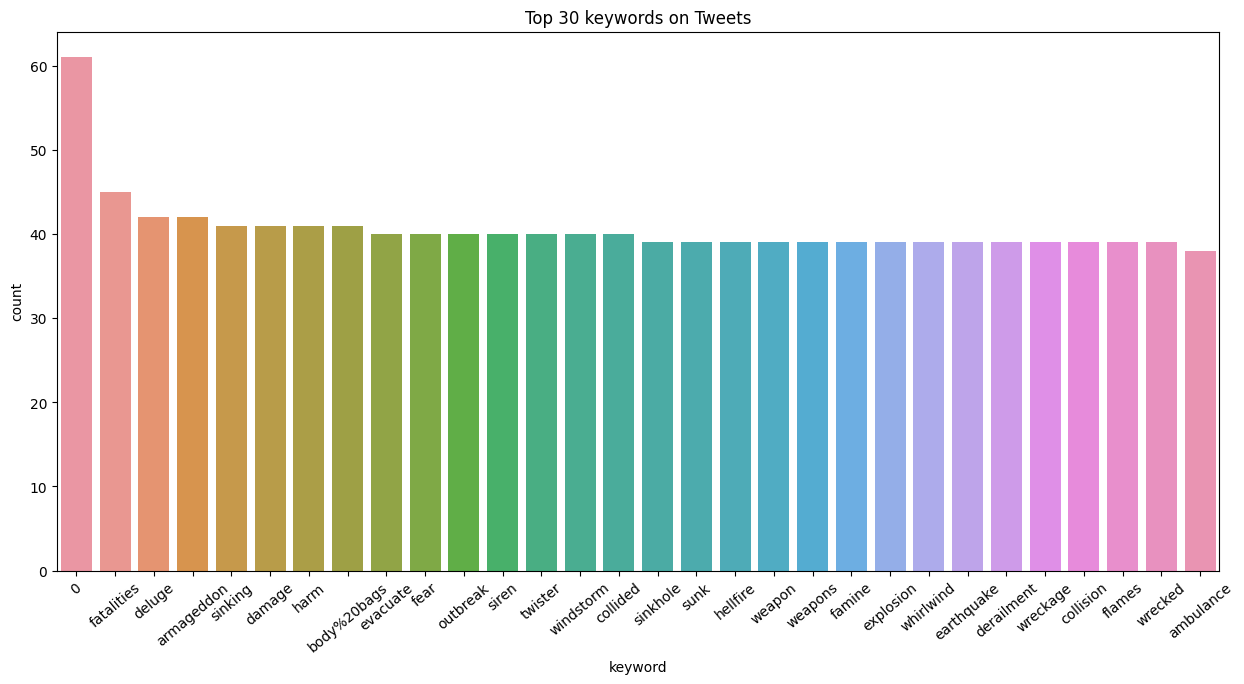

In [8]:
# Plot the top 30 keywords and their frequencies.
plt.figure(figsize=(15,7))
sns.barplot(data=keyword_df.head(30), x = 'keyword',y = 'count')
plt.xticks(rotation = 40)
plt.title('Top 30 keywords on Tweets');

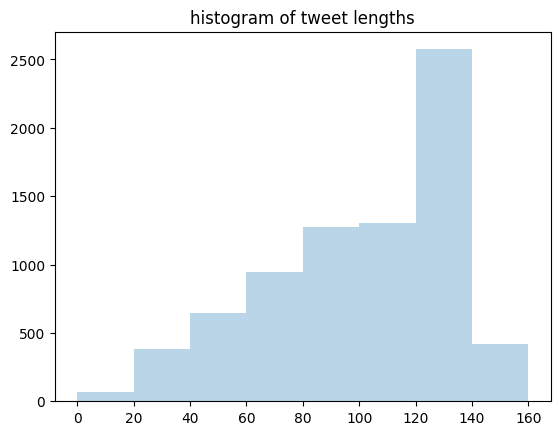

In [9]:
# Visualise the spread of tweet lengths throughout the whole training dataset.
def plot_tweet_lengths(df):
    # Find lengths.
    ldf = pd.DataFrame(columns = ['lengths'])
    i = 0
    for text in df['text']:
        ldf.loc[i, 'lengths'] = len(text)
        i = i + 1
    # plot histogram
    increments = range(0, 180, 20)
    plt.hist(ldf['lengths'],bins = increments, alpha = 0.3)
    plt.title('histogram of tweet lengths')

plot_tweet_lengths(train_df)

In [10]:
# Define a function that takes a dataset and returns a DataFrame of each tweet's length and its corresponding target value.
def sentence_lengths(df):
    ldf = pd.DataFrame(columns = ['lengths'])
    i = 0
    for text in df['text']:
        ldf.loc[i, 'lengths'] = len(text)
        i = i + 1
    return ldf


new_ldf = sentence_lengths(train_df)

merged_df = pd.concat([new_ldf, train_df["target"]], axis=1) # Set up a DataFrame with columns for lengths and the corresponding binary target value.
merged_df # Is this segment necessary?

,lengths,target
0,69,1
1,38,1
2,133,1
3,65,1
4,88,1
...,...,...
7608,83,1
7609,125,1
7610,65,1
7611,137,1


Text(0.5, 1.0, 'The dependance of target value on tweet length')

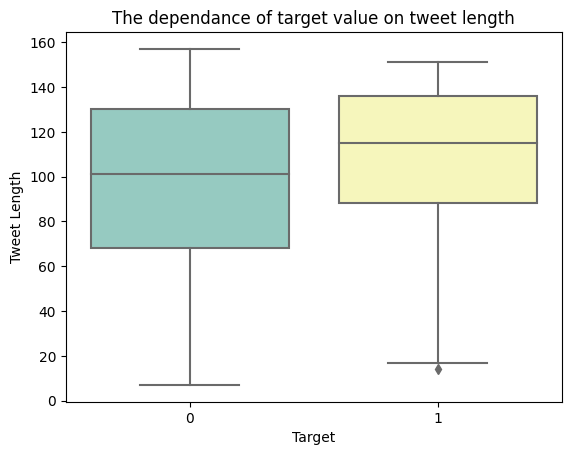

In [11]:
sns.boxplot(x = merged_df['target'], y = merged_df['lengths'], palette = 'Set3')
plt.xlabel('Target')
plt.ylabel('Tweet Length')
plt.title('The dependance of target value on tweet length')

# **Preprocessing**

In [12]:
# Load spaCy model
nlp = spacy.load('en_core_web_sm')


In [13]:
# Extract disaster-related texts
disaster_text = []
for i in tqdm(range(len(texts))):
    if train_df.target[i] == 1:
        disaster_text.append(nlp(texts[i]))


100%|██████████| 7613/7613 [00:33<00:00, 225.89it/s]


In [14]:
# Create a preprocessing function that will tokenize the text files before stripping out punctuation, links, etc...
def preprocessor(text):
    tokens = nlp(text)
    clear_token_list = [token.text for token in tokens if not token.is_punct]
    clear_token_list = [token for token in clear_token_list if not re.match(r'[^\w\s]', token)]
    clear_token_list = [token for token in clear_token_list if not re.match(r"http\S+|www\S+|https\S+", token, flags=re.MULTILINE)]
    return clear_token_list

# Apply to the text column
train_df['text'] = train_df['text'].apply(preprocessor)

# Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x)
tfidf_matrix = vectorizer.fit_transform(train_df['text']) 

print(tfidf_matrix) 

  (0, 10388)	0.1977309466408412
  (0, 18928)	0.24603114121107716
  (0, 3843)	0.39143202958221895
  (0, 782)	0.39143202958221895
  (0, 5982)	0.3008179699436269
  (0, 12725)	0.28801888110295737
  (0, 18447)	0.17397354451072639
  (0, 15801)	0.10965656387929183
  (0, 7541)	0.3449149072880065
  (0, 18392)	0.09898822569574105
  (0, 10560)	0.17397354451072639
  (0, 2865)	0.37426394379394723
  (0, 6763)	0.2812296992055223
  (1, 2140)	0.38931208514660703
  (1, 8107)	0.4713763410985762
  (1, 7774)	0.4713763410985762
  (1, 5410)	0.38001562034563063
  (1, 15607)	0.30724782919463794
  (1, 13267)	0.2473060632637861
  (1, 3841)	0.32260099393107067
  (2, 13022)	0.2133809737715508
  (2, 15906)	0.219966949610918
  (2, 15897)	0.14053618938189563
  (2, 12947)	0.1875419301676637
  (2, 15921)	0.18837338020950337
  :	:
  (7611, 12707)	0.24561024657398242
  (7611, 14471)	0.2113077417958915
  (7611, 3143)	0.2113077417958915
  (7611, 5591)	0.22827581778682327
  (7611, 10316)	0.13594970644421284
  (7611, 17397)	

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [15]:
categorical_features = ["text"]

preprocessor = ColumnTransformer(
    transformers=[
      ('tfidf', vectorizer, 'text'),  
    ]
)

In [16]:
x = train_df.iloc[:, :-1]
y = train_df.iloc[:,-1]
x.drop("id", axis=1, inplace=True)
x

,keyword,location,text
0,0,0,"[Our, Deeds, are, the, Reason, of, this, earth..."
1,0,0,"[Forest, fire, near, La, Ronge, Sask, Canada]"
2,0,0,"[All, residents, asked, to, shelter, in, place..."
3,0,0,"[13,000, people, receive, wildfires, evacuatio..."
4,0,0,"[Just, got, sent, this, photo, from, Ruby, Ala..."
...,...,...,...
7608,0,0,"[Two, giant, cranes, holding, a, bridge, colla..."
7609,0,0,"[The, out, of, control, wild, fires, in, Calif..."
7610,0,0,"[M1.94, 01:04, UTC]?5, km, S, of, Volcano, Haw..."
7611,0,0,"[Police, investigating, after, an, e, bike, co..."


# **Model evaluation**

In [17]:
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression()

clf_lg = Pipeline(
    steps = [("vectorizer", preprocessor), ("classifier", lg)]
)

clf_lg.fit(x, y)
print("model_score: %.3f" %clf_lg.score(x, y))

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


model_score: 0.887


In [18]:
from sklearn.svm import SVC

svc = SVC() 

clf_svc = Pipeline(
    steps = [("preprocessor", preprocessor), ("classifier", svc)]
)

clf_svc.fit(x, y)
print("model_score: %.3f" %clf_svc.score(x, y))

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


model_score: 0.964


In [19]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()

clf_rfc = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", rfc)]
)

clf_rfc.fit(x, y)
print('model score: %.3f' % clf_rfc.score(x, y))

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


model score: 0.988


In [20]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier()

clf_gbc = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", gbc)]
)

clf_gbc.fit(x, y)
print("model score: %.3f" % clf_gbc.score(x, y))

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


model score: 0.763


In [21]:
import xgboost

xgb = xgboost.XGBClassifier()

clf_xgb = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", xgb)]
)

clf_xgb.fit(x, y)
print("model score: %.3f" % clf_xgb.score(x, y))

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


model score: 0.861


In [22]:
from sklearn.ensemble import BaggingClassifier

bgc = BaggingClassifier()

clf_bgc = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", bgc)]
)

clf_bgc.fit(x, y)
print('model score: %.3f' % clf_bgc.score(x, y))

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


model score: 0.963


In [23]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(10, 10, 10),
                    max_iter=1000)

clf_mlp = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", mlp)]
)

clf_mlp.fit(x, y)
print("model score: %.3f" % clf_mlp.score(x, y))

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


model score: 0.988


# **Apply the most accurate model (based on the training data) and submit**

In [24]:
missing_values = test_df.isnull().sum()
print(missing_values)

id             0
keyword       26
location    1105
text           0
dtype: int64


In [25]:
test_df.fillna('0', inplace=True)

In [26]:
predictions = clf_mlp.predict(test_df)
output = pd.DataFrame({'id': test_df['id'], 'Prediction' : predictions})

In [27]:
output.to_csv('submission.csv', index = False)